In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(f'''TensorFlow: {tf.__version__}
Physical Devices: {physical_devices}''')

TensorFlow: 2.9.2
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


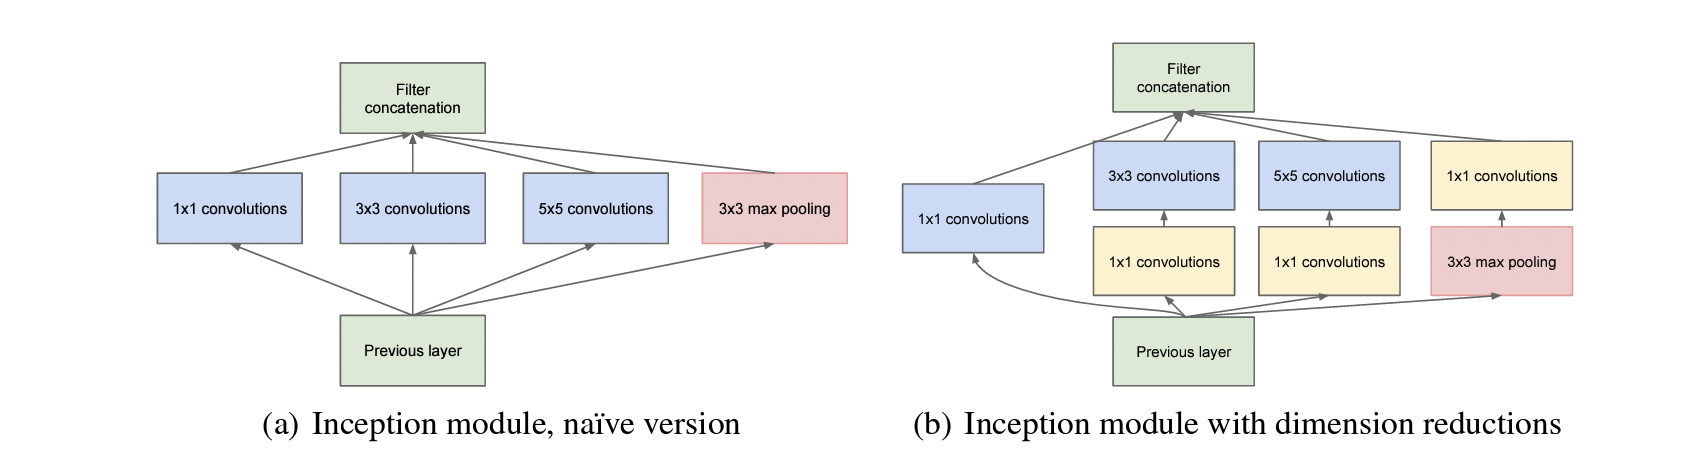

In [2]:
class ConvBlock(layers.Layer):
    def __init__(self, 
                 filters: int, 
                 kernel_size: int, 
                 strides: int, 
                 padding: str ='valid'):
        super(ConvBlock, self).__init__()
        self.conv = layers.Conv2D(filters=filters, 
                                  kernel_size=kernel_size, 
                                  strides=strides, 
                                  padding=padding)
        self.bn = layers.BatchNormalization()
        self.relu = layers.Activation('relu')
        
    def call(self, x, training=False):
        x = self.conv(x)
        x = self.bn(x, training=training)
        return self.relu(x)

In [3]:
class InceptionBlock(keras.Model):
    def __init__(self, 
                 num_1x1: int = 20, 
                 num_3x3_reduce: int = 20, 
                 num_3x3: int = 20, 
                 num_5x5_reduce: int = 20, 
                 num_5x5: int = 20, 
                 pool_proj: int = 20, 
                 layer_name: str = 'Inception'):
        super(InceptionBlock, self).__init__()
        self.conv1x1 = keras.Sequential([
            ConvBlock(filters=num_1x1, kernel_size=1, strides=1, padding='same')
        ], name=layer_name+'_1x1')
        self.conv3x3 = keras.Sequential([
            ConvBlock(filters=num_3x3_reduce, kernel_size=1, strides=1, padding='same'), 
            ConvBlock(filters=num_3x3, kernel_size=3, strides=1, padding='same')
        ], name=layer_name+'_3x3')
        self.conv5x5 = keras.Sequential([
            ConvBlock(filters=num_5x5_reduce, kernel_size=1, strides=1, padding='same'),
            ConvBlock(filters=num_5x5, kernel_size=5, strides=1, padding='same')
        ], name=layer_name+'_5x5')
        self.projection = keras.Sequential([
            layers.MaxPool2D(pool_size=3, strides=1, padding='same'), 
            ConvBlock(filters=pool_proj, kernel_size=1, strides=1, padding='same')
        ], name=layer_name+'_projection')
    
    def call(self, x, training=False):
        res1x1 = self.conv1x1(x, training=training)
        res3x3 = self.conv3x3(x, training=training)
        res5x5 = self.conv5x5(x, training=training)
        res_proj = self.projection(x, training=training)
        return layers.concatenate([res1x1, res3x3, res5x5, res_proj])
    
    def model(self):
        x = layers.Input(shape=(224, 224, 3))
        return keras.Model(inputs=[x], outputs=[self.call(x)])

In [4]:
model = InceptionBlock()
model.model().summary()

Metal device set to: Apple M1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Inception_1x1 (Sequential)     (None, 224, 224, 20  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 Inception_3x3 (Sequential)     (None, 224, 224, 20  3860        ['input_1[0][0]']                
                                )                               

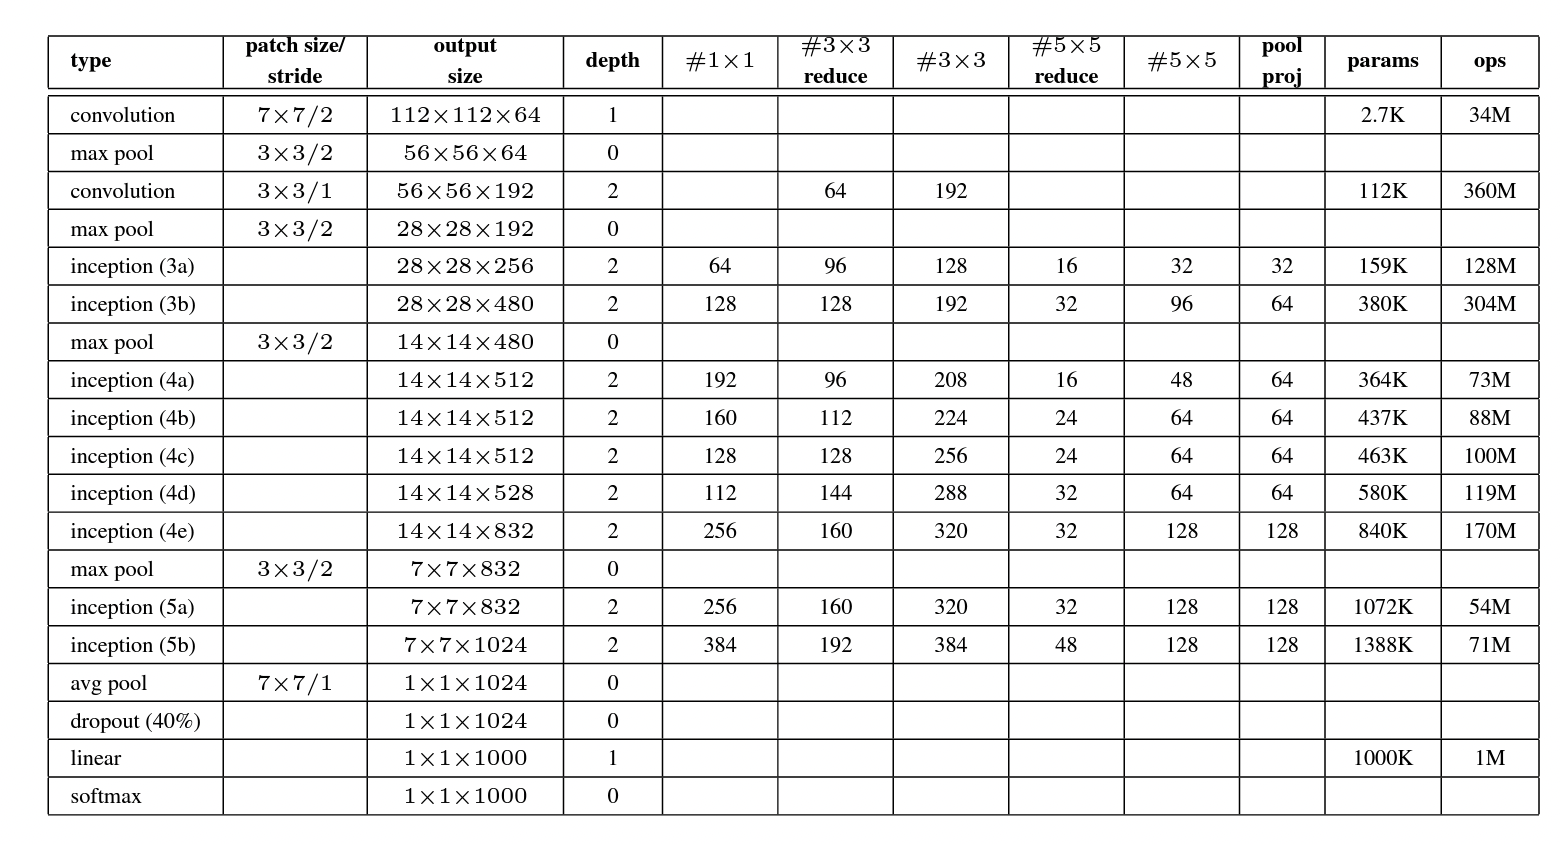

In [ ]:
class GoogLeNet(keras.Model):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.conv1 = keras.Sequential([
            ConvBlock(filters=64, kernel_size=7, strides=2, padding='valid'), 
            layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        ], name='conv1')
        
        self.conv2 =  keras.Sequential([
            ConvBlock(filters=192, kernel_size=3, strides=1, padding='same'), 
            layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        ], name='conv2')
        
        self.inception_3a = keras.Sequential([
            InceptionBlock(num_1x1=64, num_3x3_reduce=96, num_3x3=128, num_5x5_reduce=16, 
                           num_5x5=32, pool_proj=32, layer_name='Inception3a')
        ], name='Inception3a')
        
        self.inception_3b = keras.Sequential([
            InceptionBlock(num_1x1=128 num_3x3_reduce=128, num_3x3=192, num_5x5_reduce=32, 
                           num_5x5=96, pool_proj=64, layer_name='Inception3b')
        ], name='Inception3b')
        
        self.maxpool = layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        
        self.inception_4a = keras.Sequential([
            InceptionBlock(num_1x1=128 num_3x3_reduce=128, num_3x3=192, num_5x5_reduce=32, 
                           num_5x5=96, pool_proj=64, layer_name='Inception4a')
        ], name='Inception4a')
        
        self.inception_4b = keras.Sequential([
            InceptionBlock(num_1x1=128 num_3x3_reduce=128, num_3x3=192, num_5x5_reduce=32, 
                           num_5x5=96, pool_proj=64, layer_name='Inception4b')
        ], name='Inception4b')
        
        self.inception_4c = keras.Sequential([
            InceptionBlock(num_1x1=128 num_3x3_reduce=128, num_3x3=192, num_5x5_reduce=32, 
                           num_5x5=96, pool_proj=64, layer_name='Inception4c')
        ], name='Inception4c')
        
        self.inception_4d = keras.Sequential([
            InceptionBlock(num_1x1=128 num_3x3_reduce=128, num_3x3=192, num_5x5_reduce=32, 
                           num_5x5=96, pool_proj=64, layer_name='Inception4d')
        ], name='Inception4d')
        
        self.inception_4e = keras.Sequential([
            InceptionBlock(num_1x1=128 num_3x3_reduce=128, num_3x3=192, num_5x5_reduce=32, 
                           num_5x5=96, pool_proj=64, layer_name='Inception4e')
        ], name='Inception4e')